In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)

In [2]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        #defining layers
        #convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 5)
        
        #dense layers or fully connected layers
        self.fc1 = nn.Linear(in_features = 12*4*4, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 60)
        self.out = nn.Linear(in_features = 60, out_features = 10)
        
    def forward(self, t):
        #input layer
        t = t
        
        # (1) hidden layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        
        # (2) hidden layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        
        # (3) hidden layer
        #first we need to flatten while passing from convolutional layer to fully connected layer
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        
        # (4) hidden layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (5) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)
        
        return t

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

In [4]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [5]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(5):
    total_loss = 0
    total_correct = 0
    for batch in train_loader:
        images, labels = batch
        
        preds = network(images)
        loss = F.cross_entropy(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
    
    print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss,)

epoch: 0 total_correct: 46099 loss: 362.9475663602352
epoch: 1 total_correct: 51110 loss: 238.14428120851517
epoch: 2 total_correct: 52047 loss: 215.18119658529758
epoch: 3 total_correct: 52484 loss: 204.43286527693272
epoch: 4 total_correct: 52543 loss: 200.9292718321085


In [6]:
#accuracy
total_correct/len(train_set)

0.8757166666666667

In [7]:
image, label = next(iter(train_set))

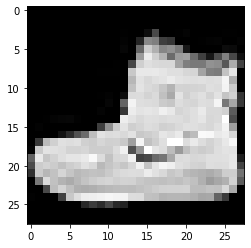

Label: 9


In [8]:
#this is an ankle boot
plt.imshow(image.squeeze(dim=0), cmap = 'gray')
plt.show()
print('Label:',label)

In [9]:
image.shape

torch.Size([1, 28, 28])

In [10]:
image.unsqueeze(0).shape #this will add an extra 1 before it

torch.Size([1, 1, 28, 28])

In [11]:
#prediction
predictions = network(image.unsqueeze(dim = 0))
#this gives 10 probabilities, take in the max probability

In [12]:
predictions.argmax(dim=1).item()

9

In [13]:
#the above prediction was correct

In [14]:
images, label = next(iter(train_loader))

In [15]:
images.shape

torch.Size([100, 1, 28, 28])

In [16]:
label.shape

torch.Size([100])

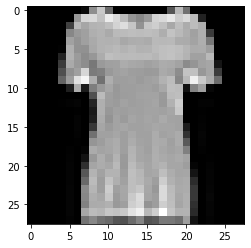

label:  tensor(0)


In [17]:
plt.imshow(images[10].squeeze(dim=0), cmap='gray')
plt.show()
print("label: ",label[10])

In [21]:
#prediction
predictions = network(images[10].unsqueeze(dim=0))
predictions.argmax(dim=1).item()
#prediction is correct

0

In [22]:
from torch.utils.tensorboard import SummaryWriter

### Starting out with TensorBoard (Network Graph and Images)

In [25]:
batch_size = 100
lr = 0.01

network = Network()
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size)
optimizer = optim.Adam(network.parameters(), lr=lr)

images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

comment = f' batch_size={batch_size} lr={lr}'
tb = SummaryWriter(comment=comment)
tb.add_image('images', grid)
tb.add_graph(network, images)

for epoch in range(10):
    total_loss = 0
    total_correct = 0
    for batch in train_loader:
        images, labels = batch
        
        preds = network(images)
        loss = F.cross_entropy(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_correct += get_num_correct(preds, labels)
    
    tb.add_scalar("Loss", total_loss, epoch)
    tb.add_scalar("Number Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", total_correct/len(train_set), epoch)
    
    #tb.add_histogram("conv1.bias", network.conv1.bias, epoch)
    #tb.add_histogram("conv1.weight", network.conv1.weight, epoch)
    #tb.add_histogram("conv1.weight.grad", network.conv1.weight.grad, epoch)
    
    for name, weight in network.named_parameters():
        tb.add_histogram(name, weight, epoch)
        tb.add_histogram(f'{name}.grad', weight.grad, epoch)
    
    print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss,)
    
tb.close()

epoch: 0 total_correct: 42199 loss: 469.6369976401329
epoch: 1 total_correct: 48042 loss: 314.9651093184948
epoch: 2 total_correct: 49863 loss: 274.86103200912476
epoch: 3 total_correct: 51019 loss: 246.5031486749649
epoch: 4 total_correct: 51801 loss: 226.2091706842184
epoch: 5 total_correct: 52266 loss: 211.52442771196365
epoch: 6 total_correct: 52658 loss: 200.17604868113995
epoch: 7 total_correct: 52998 loss: 190.87717308104038
epoch: 8 total_correct: 53191 loss: 183.1899478584528
epoch: 9 total_correct: 53433 loss: 176.64820539951324
